In [18]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from object_detection import ObjectDetection
from PIL import Image
import numpy as np

class SeaTurtleDetector(ObjectDetection):
    def __init__(self, graph_def, labels):
        super(SeaTurtleDetector, self).__init__(labels)
        self.graph = tf.compat.v1.Graph()
        with self.graph.as_default():
            input_data = tf.compat.v1.placeholder(tf.float32, [1, None, None, 3],
                                                  name='Placeholder')
            tf.import_graph_def(graph_def, input_map={"Placeholder:0": input_data},
                                name="")

    def predict(self, preprocessed_image):
        inputs = np.array(preprocessed_image, dtype=float)[:, :, (2, 1, 0)]

        with tf.compat.v1.Session(graph=self.graph) as sess:
            output_tensor = sess.graph.get_tensor_by_name('model_outputs:0')
            outputs = sess.run(output_tensor,
                               {'Placeholder:0': inputs[np.newaxis, ...]})
            return outputs[0]

def annotate_image(image, predictions, min_score=0.7, figsize=(12, 8)):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'xticks': [], 'yticks': []})
    img_width, img_height = image.size
    ax.imshow(image)

    for p in predictions:
        score = p['probability']

        if score >= min_score: 
            x1 = p['boundingBox']['left'] * img_width
            y1 = p['boundingBox']['top'] * img_height
            width = p['boundingBox']['width'] * img_width
            height = p['boundingBox']['height'] * img_height
            label = p['tagName']

            rect = Rectangle((x1, y1), width, height, fill=False, color='red', lw=2)
            ax.add_patch(rect)
            label = f'{label} ({score:.0%})'
            ax.text(x1 + (width / 2), y1, label, color='white',
                    backgroundcolor='red', ha='center', va='bottom',
                    fontweight='bold', bbox=dict(color='red'))

In [19]:
# Load the serialized model graph
graph_def = tf.compat.v1.GraphDef()
with tf.io.gfile.GFile('model.pb', 'rb') as f:
    graph_def.ParseFromString(f.read())

# Load the labels
with open('labels.txt', 'r') as f:
    labels = [l.strip() for l in f.readlines()]

# Create the model
model = SeaTurtleDetector(graph_def, labels)

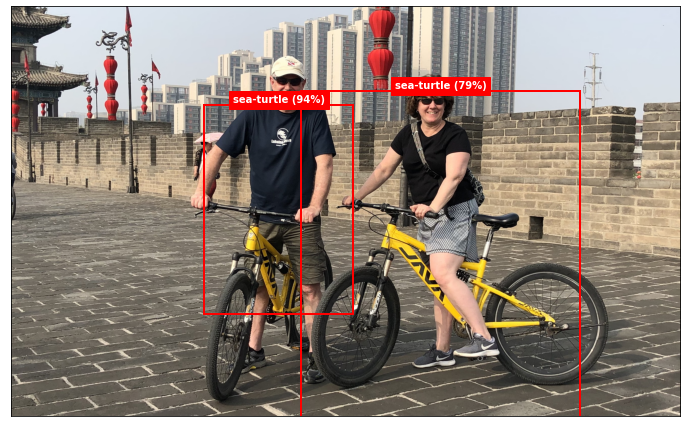

In [20]:
%matplotlib inline

image = Image.open('Data/xian.jpg')
predictions = model.predict_image(image)
annotate_image(image, predictions)